# Part 2 - Speeding up MMPBSA/MMGBSA Calculations

By Thanh Lai

<img alt="MMPBSA" src="http://ambermd.org/tutorials/advanced/tutorial3/images/figure2.gif" width="60%">

Image from: http://ambermd.org/tutorials/advanced/tutorial3/

---
# Abstract

The second part of the project is optimization of the MMPBSA and MMGBSA program on HPCC (the program has already been installed and compiled on the server). Free energy calculation is used in my research a lot because it give important details on the stability of molecular complexes, which is useful for predicting drug candidates, toxicity, and biological mechanisms. My lab uses the MMPBSA/MMGBSA program for free energy calculation, which is known to be fast relative to other free energy methods. Using the data of a molecular dynamics simulation, at each timestep it calculates the free energy of binding between the ligand and protein (scheme is shown in the 2nd image above). MMPBSA and MMGBSA only differs in the method used for calculating the polar solvation energy. MMPBSA calculates the solvation energy exactly using the Poisson-Boltzmann (PB) equation, while MMGBSA estimates the solvation energy using the approximate Generalized Born equation. Therfore, MMPBSA tends to take longer than MMGBSA. This optimization study will use sorafenib complexed with the VEGFR2 protein for the free energy calculations. Sorafenib is a cancer drug that targets multiple kinases in the human body. MMPBSA/MMGBSA calculation was sped up by using the MPI version from 2 to 64 nodes (in powers of 2). One node is assigned to one frame of the simulation (250 frames total). The scheme was tested in amd20-v100 and intel16-k80. amd20-v100 is faster than intel16-k80 until 16 nodes, in which both dev-nodes had similar computing time afterward. The scaling for both GBSA and PBSA matches the results of Miller et. Al. (dx.doi.org/10.1021/ct300418h).

---
# Methodology

From the repository root directory:
```bash
cd part2
mkdir serial
mkdir mpi
cd serial
sbatch ../jobfiles/mmpbsa.sb
cd ../mpi
sbatch ../jobfiles/mmpbsa-mpi.sb
```
`part2/data` should contain the following simulation files:
```
complex_rdy.top: the topology file of the solvated ligand + protein complex
complex_dry.top: the topology file of the unsolvated ligand + protein complex
prot.top: the topology of the protein only
lig.top: the topology of the ligand only
md.mdcrd: the trajectory of the simulation
```

Change mmpbsa-mpi.sb node usage by the `#SBATCH --ntask` flag  
The results will be stored in `mdout-serial.dat` or `mdout-mpi.dat`. The calculation time is in `mmpbsa.o*` or `mmpbsa-mpi.o*`. Output files are located in `part2/serial/` or `part2/mpi/` directories.  

I ran both serial and mpi on amd20-v100 and intel16-k80. For the mpi version I used 2, 4, 8, 16, 32, 64 nodes.

---
# Timing Results


## MOLECULAR DYNAMICS SIMULATION (GPU)
**MACHINE:** intel16-k80  
**DATA:** PDB ID: 3WZE; PDB was prepared with Molecular Operating Environment and equilibrated by standard minimizing->heating  
**METHOD:** 1 nanosecond equilibrium Molecular Dynamics  
**RESULTS:** 01:14:33  


## SERIAL MMPBSA/MMGBSA
**MACHINE:** amd20-v100  
**DATA:** First 1 nanosecond MD simulation of sorafenib (cancer drug) complexed with VGEFR2 in 2 frame intervals  
**METHOD:** MMGBSA + MMPBSA combined in one jobfile  
**RESULTS:** 04:02:24

**MACHINE:** intel16-k80  
**DATA:** First 1 nanosecond MD simulation of sorafenib (cancer drug) complexed with VGEFR2 in 2 frame intervals  
**METHOD:** MMGBSA + MMPBSA combined in one jobfile  
**RESULTS:** 04:02:39  

**Comments:** It is not surprising that the MMPBSA/MMGBSA calculations are the same speed on both machines since it doesn't use GPU. However I had to run it on these dev-nodes because one of the modules I need to load AMBER18 requires GPU. Part 2 of this project will be optimizing submission script to run the MPI version of MMPBSA/MMGBSA.


## MPI MMPBSA/MMGBSA

### amd20-v100 (minutes)

| Nodes | GBSA | PBSA   |
|-------|------|--------|
| 2     | 9.18 | 154.68 |
| 4     | 4.56 | 77.10  |
| 8     | 1.94 | 28.93  |
| 16    | 1.40 | 23.10  |
| 32    | 1.16 | 12.69  |
| 64    | 2.03 | 4.41   |

### intel16-k80 (minutes)

| Nodes | GBSA | PBSA   |
|-------|------|--------|
| 2     | 9.18 | 153.78 |
| 4     | 6.72 | 132.66 |
| 8     | 2.40 | 39.03  |
| 16    | 1.43 | 23.93  |
| 32    | 1.18 | 12.67  |
| 64    | 5.23 | 5.14   |

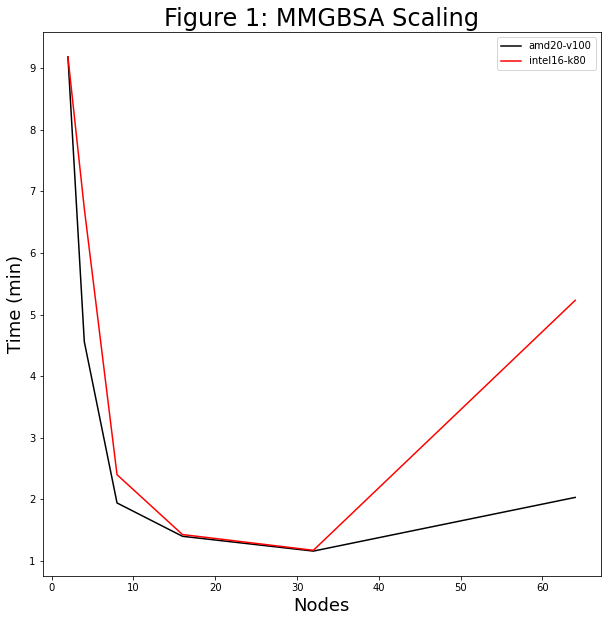

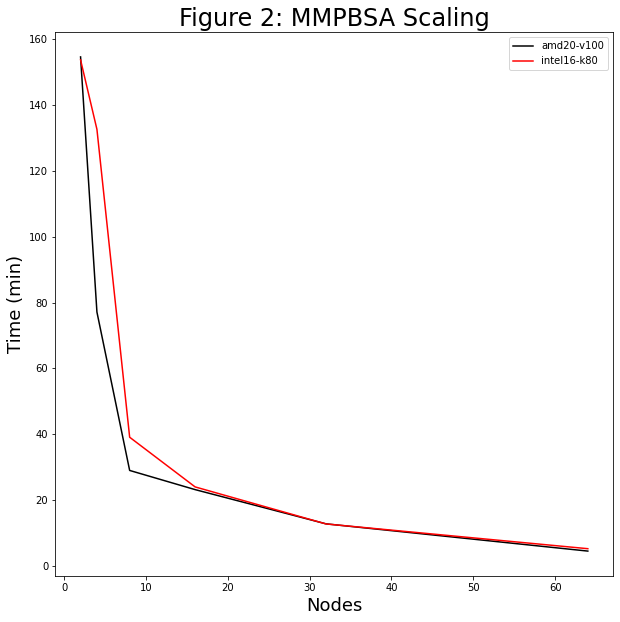

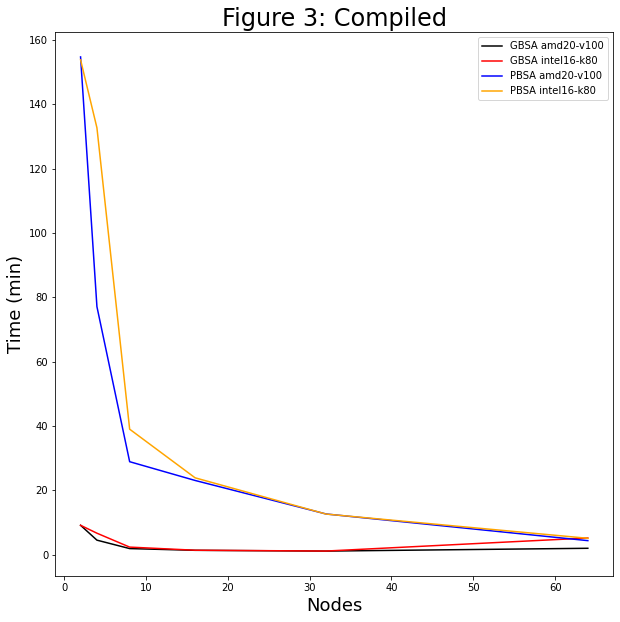

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
x = [2, 4, 8, 16, 32, 64]
plt.plot(x, [9.18, 4.56, 1.943, 1.402, 1.162, 2.033], color="black", label="amd20-v100")
plt.plot(x, [9.18, 6.72, 2.401, 1.43, 1.175, 5.231], color="red", label="intel16-k80")
plt.title("Figure 1: MMGBSA Scaling", size=24)
plt.xlabel("Nodes", size=18)
plt.ylabel("Time (min)", size=18)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(x, [154.68, 77.1, 28.932, 23.102, 12.693, 4.409], color="black", label="amd20-v100")
plt.plot(x, [153.78, 132.66, 39.031, 23.926, 12.666, 5.137], color="red", label="intel16-k80")
plt.title("Figure 2: MMPBSA Scaling", size=24)
plt.xlabel("Nodes", size=18)
plt.ylabel("Time (min)", size=18)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
x = [2, 4, 8, 16, 32, 64]
plt.plot(x, [9.18, 4.56, 1.943, 1.402, 1.162, 2.033], color="black", label="GBSA amd20-v100")
plt.plot(x, [9.18, 6.72, 2.401, 1.43, 1.175, 5.231], color="red", label="GBSA intel16-k80")
plt.plot(x, [154.68, 77.1, 28.932, 23.102, 12.693, 4.409], color="blue", label="PBSA amd20-v100")
plt.plot(x, [153.78, 132.66, 39.031, 23.926, 12.666, 5.137], color="orange", label="PBSA intel16-k80")
plt.title("Figure 3: Compiled", size=24)
plt.xlabel("Nodes", size=18)
plt.ylabel("Time (min)", size=18)
plt.legend()
plt.show()

### Figure 4: Scaling study done by Miller et. Al.

<img alt="SCALING" src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jctcce/2012/jctcce.2012.8.issue-9/ct300418h/production/images/large/ct-2012-00418h_0003.jpeg" width="60%">

IMAGE URL: dx.doi.org/10.1021/ct300418h


# Discussion

MMGBSA and MMPBSA MPI scaling (figure 1 and 2) is very similar to the scaling reported in literature (figure 4). Interestingly, both MMGBSA and MMPBSA, amd20-v100 is faster than intel16-k80 until after 16 nodes, by which they have essentially the same calculation times. This shows that at some point the speed up from MPI overshadows the speed up difference between the two dev-nodes. There is a discrepancy in the MMGBSA scaling at 64 nodes (figure 1), where the intel16-k80 dev-node performs nearly 5 times longer than 32 nodes. It does not appear to be an error, since I ran it a second time and got similar results. When compiling MMPBSA and MMGBSA results into one graph (figure 3), it is obvious that the calculations converges almost to the same asymptote. This makes sense because there is a limit of speed up.

---
# Concluding Discussion and Future Work

The scaling behaves very similarly to the results of Miller et. Al. After 16 nodes, the speed up of MPI overshadows the marginal speed up of amd20-v100 over intel16-k80. All instances converges to a similar asymptote, which indicates a limit of speed up. The next step is to do a similar scaling study to MMPBSA/MMGBSA NMode, which takes nearly double the amount of time to calculate than regular MMPBSA/MMGBSA.

---
# References

1. https://thisdavej.com/copy-table-in-excel-and-paste-as-a-markdown-table/
2. https://doi.org/10.1021/ct300418h
3. https://ambermd.org/tutorials/advanced/tutorial3/py_script/section4.htm

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----